# **Machine Learning Sentiment Analysis of Text Data Capstone Project**

## **Introduction**

One of the most important things to learn in the field of data science is sentiment analysis, and there are several sources from which we can bring data for analysis. One of these sources is the tweets that we can take from the Twitter site. Big data that we can use greatly to predict the condition of people and what they feel through their post, and determine whether the person’s feelings are negative, positive or neutral. In this notebook, I will analyze these tweets to predict the percentage of people with negative, positive and neutral emotions.

So before we start everything let's call up the most important libraries that we will use

In [1]:
!pip install emoji

In [2]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import re
import matplotlib.pyplot as plt
import plotly.express as px
from geotext import GeoText
from nltk.stem import LancasterStemmer, SnowballStemmer, RegexpStemmer, WordNetLemmatizer 
import nltk
nltk.download('punkt')
from nltk import sent_tokenize
from nltk import word_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import string
import emoji
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud,STOPWORDS

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning:

The twython library has not been installed. Some functionality from the twitter package will not be available.



Here we will read the data called Covid 19 Tweets

In [3]:
df = pd.read_csv('covid19_tweets (1).csv')
df.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...,NaN,Twitter for iPhone,False
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN,Twitter for Android,False
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,False
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs ...,2019-03-07 01:45:06,197,987,1488,False,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...,['COVID19'],Twitter for iPhone,False
4,DIPR-J&K,Jammu and Kashmir,🖊️Official Twitter handle of Department of Inf...,2017-02-12 06:45:15,101009,168,101,False,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False


Let's show some information and description about this data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179108 entries, 0 to 179107
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   user_name         179108 non-null  object
 1   user_location     142337 non-null  object
 2   user_description  168822 non-null  object
 3   user_created      179108 non-null  object
 4   user_followers    179108 non-null  int64 
 5   user_friends      179108 non-null  int64 
 6   user_favourites   179108 non-null  int64 
 7   user_verified     179108 non-null  bool  
 8   date              179108 non-null  object
 9   text              179108 non-null  object
 10  hashtags          127774 non-null  object
 11  source            179031 non-null  object
 12  is_retweet        179108 non-null  bool  
dtypes: bool(2), int64(3), object(8)
memory usage: 15.4+ MB


In [5]:
df.describe()

,user_followers,user_friends,user_favourites
count,1.791080e+05,179108.000000,1.791080e+05
mean,1.090555e+05,2121.701566,1.444411e+04
std,8.414670e+05,9162.553072,4.452270e+04
min,0.000000e+00,0.000000,0.000000e+00
25%,1.720000e+02,148.000000,2.060000e+02
50%,9.920000e+02,542.000000,1.791000e+03
75%,5.284000e+03,1725.250000,9.388000e+03
max,4.944256e+07,497363.000000,2.047197e+06


Here, we will display the nan ratio in each column and represent it on a heat map

In [6]:
df.isnull().sum()/len(df)

user_name           0.000000
user_location       0.205301
user_description    0.057429
user_created        0.000000
user_followers      0.000000
user_friends        0.000000
user_favourites     0.000000
user_verified       0.000000
date                0.000000
text                0.000000
hashtags            0.286609
source              0.000430
is_retweet          0.000000
dtype: float64

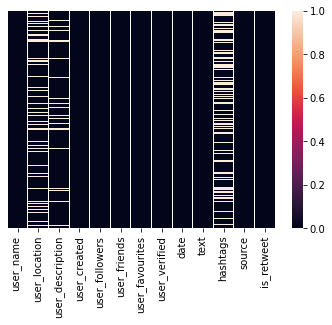

In [7]:
sns.heatmap(df.isnull(), cbar=True, yticklabels=False)

Here we will show the percentage of unique values for each column and represent it by subplot

In [8]:
df.nunique()

user_name            92276
user_location        26920
user_description     89200
user_created         93708
user_followers       27694
user_friends         11022
user_favourites      35259
user_verified            2
date                136611
text                178683
hashtags             52640
source                 610
is_retweet               1
dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



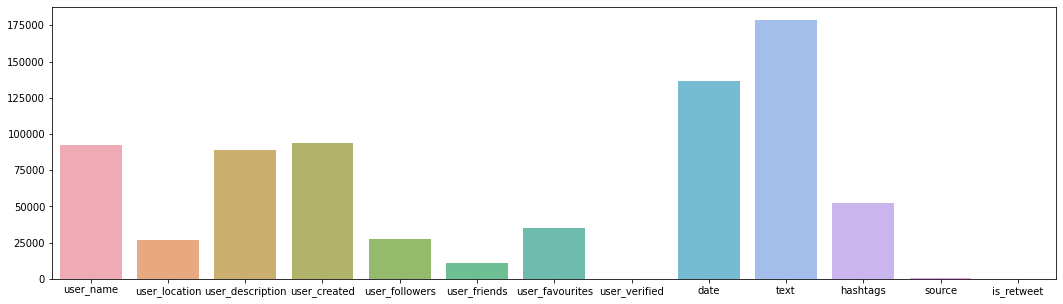

In [9]:
f, ax = plt.subplots(1,1, figsize=(18,5))
sns.barplot(df.columns, y=df.nunique(), alpha=0.8)

## **Data Cleaning**

Here we will take the text in the data, because we will clean and work on it

In [10]:
tweets=pd.DataFrame(df['text'])
tweets.head()

,text
0,If I smelled the scent of hand sanitizers toda...
1,Hey @Yankees @YankeesPR and @MLB - wouldn't it...
2,@diane3443 @wdunlap @realDonaldTrump Trump nev...
3,@brookbanktv The one gift #COVID19 has give me...
4,25 July : Media Bulletin on Novel #CoronaVirus...


we will be start with the regular expressions, this function will determine if there is an emoji or not, if there is an emoji in the text to delete it.

In [11]:
import re
def char_is_emoji(character):
    return character in emoji.UNICODE_EMOJI
#does the text contain an emoji?
def text_has_emoji(text):
    for character in text:
        if character in emoji.UNICODE_EMOJI:
            return True
    return False
#remove the emoji
def deEmojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')

This function will determine whether or not there are punctuation marks, and if any, we will delete them

In [12]:
punct =[]
punct += list(string.punctuation)
punct += '’'
punct.remove("'")
def remove_punctuations(text):
    for punctuation in punct:
        text = text.replace(punctuation, ' ')
    return text

### Here we will add two columns, the first column is the text after cleaning, and the second column is to make sure that there are no emojis

This function will determine if there are any white spaces, hyperlinks, and remove the "s" that were created after removing the punctuation. We will also check again if there is an emoji or not, and we will also lowercase the letters.

In [13]:
def nlp(df):
    df['token'] = df['text'].apply(lambda x: x.lower()) 
    df['token'] = df['token'].apply(lambda x: x.replace('\n', ' '))
    df['token'] = df['token'].str.replace('http\S+|www.\S+', '', case=False)
    df['token'] = df['token'].apply(lambda x: x.replace('&gt;', ''))
    df['emoji'] = df['token'].apply(lambda x: text_has_emoji(x))
    df['token'] = df['token'].apply(lambda x: str(x).replace(" s ", " "))
    return df

Well, let's apply the function and print in a new variable called Tweets 1

In [14]:
tweets1=(nlp(tweets))

In [15]:
(tweets1)

,text,token,emoji
0,If I smelled the scent of hand sanitizers toda...,if i smelled the scent of hand sanitizers toda...,False
1,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,hey @yankees @yankeespr and @mlb - wouldn't it...,False
2,@diane3443 @wdunlap @realDonaldTrump Trump nev...,@diane3443 @wdunlap @realdonaldtrump trump nev...,False
3,@brookbanktv The one gift #COVID19 has give me...,@brookbanktv the one gift #covid19 has give me...,False
4,25 July : Media Bulletin on Novel #CoronaVirus...,25 july : media bulletin on novel #coronavirus...,False
...,...,...,...
179103,Thanks @IamOhmai for nominating me for the @WH...,thanks @iamohmai for nominating me for the @wh...,False
179104,2020! The year of insanity! Lol! #COVID19 http...,2020! the year of insanity! lol! #covid19,False
179105,@CTVNews A powerful painting by Juan Lucena. I...,@ctvnews a powerful painting by juan lucena. i...,False
179106,"More than 1,200 students test positive for #CO...","more than 1,200 students test positive for #co...",False


## Sentiment Analysis & Tokenization

Here we will analyze the text, and find out whether the feelings are negative, positive or Neutral

In [16]:
def categoriser(diction):
    if(diction['neg']>0):
        return("Negative")
    elif(diction['pos']>0):
        return('Positive')
    else:
        return('Neutral')

Sentiment Analysis is the process of ‘computationally’ determining whether a piece of writing is positive, negative or neutral. It’s also known as opinion mining, deriving the opinion or attitude of a speake.
VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media. VADER uses a combination of A sentiment lexicon is a list of lexical features (e.g., words) which are generally labeled according to their semantic orientation as either positive or negative. VADER not only tells about the Positivity and Negativity score but also tells us about how positive or negative a sentiment is.

In [17]:
def SentiAnlyser(df):
    analyser= SentimentIntensityAnalyzer()
    df['sentiment']=df['token'].apply(lambda x: analyser.polarity_scores(x))
    df['sentiment']=df['sentiment'].apply(lambda x:categoriser(x))
    return df

In [18]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [19]:
tweets2=SentiAnlyser(tweets1)

As we can see here, we have a new column called sentiment, to determine if the text is negative, positive, or neuterl, or Neutral

In [20]:
tweets2.head()

,text,token,emoji,sentiment
0,If I smelled the scent of hand sanitizers toda...,if i smelled the scent of hand sanitizers toda...,False,Positive
1,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,hey @yankees @yankeespr and @mlb - wouldn't it...,False,Negative
2,@diane3443 @wdunlap @realDonaldTrump Trump nev...,@diane3443 @wdunlap @realdonaldtrump trump nev...,False,Negative
3,@brookbanktv The one gift #COVID19 has give me...,@brookbanktv the one gift #covid19 has give me...,False,Positive
4,25 July : Media Bulletin on Novel #CoronaVirus...,25 july : media bulletin on novel #coronavirus...,False,Positive


here is some information about the new data that called tweets 2

In [21]:
tweets2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179108 entries, 0 to 179107
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   text       179108 non-null  object
 1   token      179108 non-null  object
 2   emoji      179108 non-null  bool  
 3   sentiment  179108 non-null  object
dtypes: bool(1), object(3)
memory usage: 4.3+ MB


Here we will draw a plot for the sentiment column, to see if the values are palanced or not , if it's not , we will apply   PCA

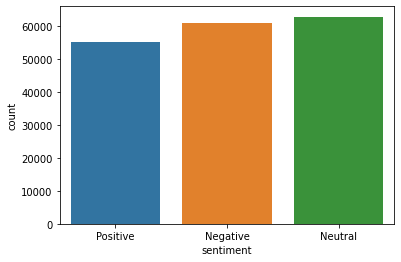

In [22]:
sns.countplot(x='sentiment',data=tweets2)

here we will check if there is any empty text

In [23]:
tweets2 = tweets2[tweets2['text'] != "Not Available"]

after that , we will apply another function that will remove all URL's, usernames , special characters and numbers

In [24]:
def clean_tweets(tweet3):
    
    tweet3 = re.sub(r"http\S+", "", tweet3)
    tweet3 = re.sub(r"@[^\s]+[\s]?",'',tweet3)
    tweet3 = re.sub('[^ a-zA-Z0-9]', '', tweet3)
    tweet3 = re.sub('[0-9]', '', tweet3)
    
    return tweet3

In [25]:
tweets2['text'] = tweets2['text'].apply(clean_tweets)

In [26]:
tweets2['text'].head()

0    If I smelled the scent of hand sanitizers toda...
1    Hey and  wouldnt it have made more sense to ha...
2    Trump never once claimed COVID was a hoax We a...
3    The one gift COVID has give me is an appreciat...
4     July  Media Bulletin on Novel CoronaVirusUpda...
Name: text, dtype: object

and here we will tokenized the text columns

In [27]:
tt = TweetTokenizer()
tweets2['text'].apply(tt.tokenize)

0         [If, I, smelled, the, scent, of, hand, sanitiz...
1         [Hey, and, wouldnt, it, have, made, more, sens...
2         [Trump, never, once, claimed, COVID, was, a, h...
3         [The, one, gift, COVID, has, give, me, is, an,...
4         [July, Media, Bulletin, on, Novel, CoronaVirus...
                                ...                        
179103    [Thanks, for, nominating, me, for, the, WearAM...
179104                [The, year, of, insanity, Lol, COVID]
179105    [A, powerful, painting, by, Juan, Lucena, Its,...
179106    [More, than, students, test, positive, for, CO...
179107                     [I, stop, when, I, see, a, Stop]
Name: text, Length: 179108, dtype: object

Stemming is the process of producing morphological variants of a root/base word. Stemming programs are commonly referred to as stemming algorithms or stemmers. A stemming algorithm reduces the words “chocolates”, “chocolatey”, “choco” to the root word, “chocolate” and “retrieval”, “retrieved”, “retrieves” reduce to the stem “retrieve”.

In [28]:
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

ps = PorterStemmer()

In [29]:
def tokenize(text):
    return word_tokenize(text)

def stemming(words):
    stem_words = []
    for w in words:
        w = ps.stem(w)
        stem_words.append(w)
    
    return stem_words

after we apply the tokenization and stemming , we will add another column called new_tokenized that we apply the function above on it

In [30]:
tweets2['new_tokenized'] = tweets2['text'].apply(tokenize)

In [31]:
tweets2.head()

,text,token,emoji,sentiment,new_tokenized
0,If I smelled the scent of hand sanitizers toda...,if i smelled the scent of hand sanitizers toda...,False,Positive,"[If, I, smelled, the, scent, of, hand, sanitiz..."
1,Hey and wouldnt it have made more sense to ha...,hey @yankees @yankeespr and @mlb - wouldn't it...,False,Negative,"[Hey, and, wouldnt, it, have, made, more, sens..."
2,Trump never once claimed COVID was a hoax We a...,@diane3443 @wdunlap @realdonaldtrump trump nev...,False,Negative,"[Trump, never, once, claimed, COVID, was, a, h..."
3,The one gift COVID has give me is an appreciat...,@brookbanktv the one gift #covid19 has give me...,False,Positive,"[The, one, gift, COVID, has, give, me, is, an,..."
4,July Media Bulletin on Novel CoronaVirusUpda...,25 july : media bulletin on novel #coronavirus...,False,Positive,"[July, Media, Bulletin, on, Novel, CoronaVirus..."


here we will count the most common words in the new tokenized column


In [32]:
from collections import Counter
words = Counter()
for idx in tweets2.index:
    words.update(tweets2.loc[idx, "new_tokenized"])

In [33]:
words.most_common(10)

[('the', 89369),
 ('COVID', 85550),
 ('to', 72676),
 ('of', 58647),
 ('in', 49879),
 ('a', 42793),
 ('and', 42708),
 ('is', 32588),
 ('for', 29557),
 ('on', 22219)]

Stop Words: A stop word is a commonly used word (such as “the”, “a”, “an”, “in”) that a search engine has been programmed to ignore, both when indexing entries for searching and when retrieving them as the result of a search query.

In [34]:
nltk.download('stopwords')
stopwords=nltk.corpus.stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


here we will make a white list contain 'not & n't' ,because it's an important word in our analysis

In [35]:
whitelist = ["n't", "not"]
#whitelist = []
whitelist 

["n't", 'not']

after that we will delete all the stopwords , except the white list word 'not' and count the most comon words

In [36]:
for idx, stop_word in enumerate(stopwords):
    if stop_word not in whitelist:
        del words[stop_word]
words.most_common(10)

[('COVID', 85550),
 ('cases', 16288),
 ('The', 14626),
 ('Covid', 14130),
 ('I', 13268),
 ('amp', 12233),
 ('new', 10857),
 ('covid', 9733),
 ('coronavirus', 9273),
 ('not', 8783)]

and here we will apply a function that call world list , this finction use to delete the stop words  and add it to the new_tokenized column

In [37]:
def word_list(processed_data):
    min_occurrences=3 
    max_occurences=500 
    stopwords=nltk.corpus.stopwords.words("english")
    whitelist = ["n't","not"]
    wordlist = []
    
    whitelist = whitelist if whitelist is None else whitelist
    words = Counter()
    for idx in processed_data.index:
        words.update(processed_data.loc[idx, "new_tokenized"])

    for idx, stop_word in enumerate(stopwords):
        if stop_word not in whitelist:
            del words[stop_word]

    word_df = pd.DataFrame(data={"word": [k for k, v in words.most_common() if min_occurrences < v < max_occurences],
                                 "occurrences": [v for k, v in words.most_common() if min_occurrences < v < max_occurences]},
                           columns=["word", "occurrences"])
    
    word_df.to_csv("wordlist.csv", index_label="idx")
    wordlist = [k for k, v in words.most_common() if min_occurrences < v < max_occurences]

In [38]:
word_list(tweets2)

## **Classification**

the first step < is to drop sentiment column because we will make a classifier based on it

In [39]:
X = tweets2.drop('sentiment', axis=1)
X.head()

,text,token,emoji,new_tokenized
0,If I smelled the scent of hand sanitizers toda...,if i smelled the scent of hand sanitizers toda...,False,"[If, I, smelled, the, scent, of, hand, sanitiz..."
1,Hey and wouldnt it have made more sense to ha...,hey @yankees @yankeespr and @mlb - wouldn't it...,False,"[Hey, and, wouldnt, it, have, made, more, sens..."
2,Trump never once claimed COVID was a hoax We a...,@diane3443 @wdunlap @realdonaldtrump trump nev...,False,"[Trump, never, once, claimed, COVID, was, a, h..."
3,The one gift COVID has give me is an appreciat...,@brookbanktv the one gift #covid19 has give me...,False,"[The, one, gift, COVID, has, give, me, is, an,..."
4,July Media Bulletin on Novel CoronaVirusUpda...,25 july : media bulletin on novel #coronavirus...,False,"[July, Media, Bulletin, on, Novel, CoronaVirus..."


let's check the columns sentiment unique valuse to see if ther is any word than positive m negative and neutral

In [40]:
target_names = tweets2['sentiment'].unique()
target_names

array(['Positive', 'Negative', 'Neutral'], dtype=object)

here we will do a dictionary for the sentiment and give value for each one 

In [41]:
target_dict = {n:i for i, n in enumerate(target_names)}
target_dict

{'Negative': 1, 'Neutral': 2, 'Positive': 0}

In [42]:
y= tweets2['sentiment'].map(target_dict)
y.head(10)

0    0
1    1
2    1
3    0
4    0
5    1
6    2
7    2
8    0
9    0
Name: sentiment, dtype: int64

In [43]:
y.unique()

array([0, 1, 2])

In [44]:
from keras.utils.np_utils import to_categorical

In [45]:
y_cat = to_categorical(y)

In [46]:
y_cat[50:60]

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.]], dtype=float32)

In [47]:
tweets2[50:60]

,text,token,emoji,sentiment,new_tokenized
50,Coronavirus Testing Fiasco St Mirrenhave pledg...,coronavirus testing fiasco: st mirren have ple...,False,Negative,"[Coronavirus, Testing, Fiasco, St, Mirrenhave,..."
51,Coronavirus Testing Fiasco St Mirrenhave pledg...,coronavirus testing fiasco: st mirren have ple...,False,Negative,"[Coronavirus, Testing, Fiasco, St, Mirrenhave,..."
52,Coronavirus Testing Fiasco St Mirrenhave pledg...,coronavirus testing fiasco: st mirren have ple...,False,Negative,"[Coronavirus, Testing, Fiasco, St, Mirrenhave,..."
53,Testing per lakh population in Jammu and Kash...,testing per 10 lakh population in jammu and ka...,False,Positive,"[Testing, per, lakh, population, in, Jammu, an..."
54,Coronavirus Testing Fiasco St Mirrenhave pledg...,coronavirus testing fiasco: st mirren have ple...,False,Negative,"[Coronavirus, Testing, Fiasco, St, Mirrenhave,..."
55,Coronavirus Testing Fiasco St Mirrenhave pledg...,coronavirus testing fiasco: st mirren have ple...,False,Negative,"[Coronavirus, Testing, Fiasco, St, Mirrenhave,..."
56,reporting that yesterday people died of COVID...,.@nytimes reporting that yesterday 1145 people...,False,Negative,"[reporting, that, yesterday, people, died, of,..."
57,Crazy that the world has come to this but as A...,crazy that the world has come to this but as a...,True,Negative,"[Crazy, that, the, world, has, come, to, this,..."
58,People whose relatives have died from COVID sh...,@jimsciutto @joannbaldwin55 people whose relat...,False,Negative,"[People, whose, relatives, have, died, from, C..."
59,US CoronaVirus cases and deaths reported in ...,"us #coronavirus: 4,249,584 cases and 148,521 d...",False,Positive,"[US, CoronaVirus, cases, and, deaths, reported..."


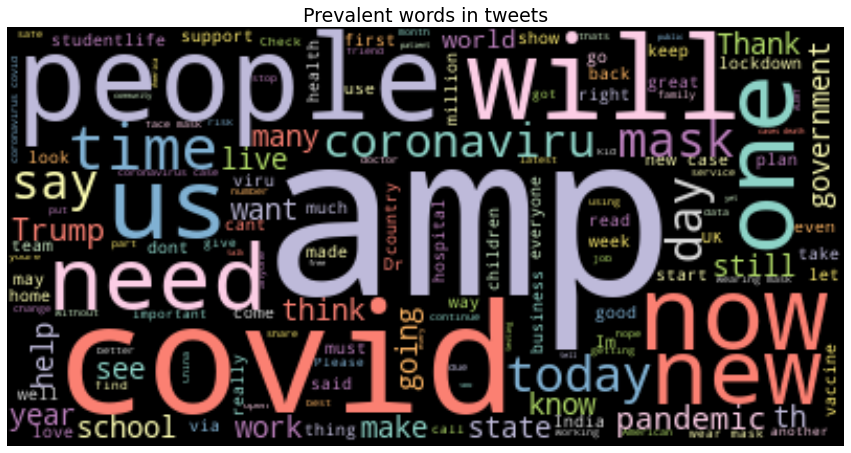

In [48]:
text = ",".join(review for review in tweets2.text if 'COVID' not in review and 'https' not in review and 'Covid' not in review)
wordcloud = WordCloud(max_words=200, colormap='Set3',background_color="black").generate(text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.figure(1,figsize=(12, 12))
plt.title('Prevalent words in tweets',fontsize=19)
plt.show()

In [49]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD, Adam, Adagrad

### here we will start the classification

first , we have to apply the train test split method.

stratification means that the train_test_split method returns training and test subsets that have the same proportions of class labels as the input dataset.


In [50]:
train,valid = train_test_split(tweets2,test_size = 0.2,random_state=0,stratify = tweets2.sentiment.values)
print("train shape : ", train.shape)
print("valid shape : ", valid.shape)

train shape :  (143286, 5)
valid shape :  (35822, 5)


In [51]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
stop = list(stopwords.words('english'))
vectorizer = CountVectorizer(decode_error = 'replace',stop_words = stop)

X_train = vectorizer.fit_transform(train.text.values)
X_valid = vectorizer.transform(valid.text.values)

y_train = train.sentiment.values
y_valid = valid.sentiment.values

print("X_train.shape : ", X_train.shape)
print("X_train.shape : ", X_valid.shape)
print("y_train.shape : ", y_train.shape)
print("y_valid.shape : ", y_valid.shape)

X_train.shape :  (143286, 106370)
X_train.shape :  (35822, 106370)
y_train.shape :  (143286,)
y_valid.shape :  (35822,)


In [52]:
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from IPython.display import Markdown as md

Naive Bayes classifier for multinomial models

The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.

after we apply multinomial Naive Bayes classifier , we will see the confusion matrix and the accuracy scorefor this cllassifier

In [53]:
from sklearn.naive_bayes import MultinomialNB

naive_clf = MultinomialNB()

naive_clf.fit(X_train,y_train)

prediction = naive_clf.predict(X_valid)
accuracy = accuracy_score(y_valid,prediction)
print("training accuracy Score    : ",naive_clf.score(X_train,y_train))
print("Validation accuracy Score : ",accuracy )
print(classification_report(prediction,y_valid))


training accuracy Score    :  0.8634409502672976
Validation accuracy Score :  0.771788286527832
              precision    recall  f1-score   support

    Negative       0.86      0.71      0.78     14879
     Neutral       0.71      0.87      0.78     10244
    Positive       0.75      0.77      0.76     10699

    accuracy                           0.77     35822
   macro avg       0.77      0.78      0.77     35822
weighted avg       0.78      0.77      0.77     35822



This estimator implements regularized linear models with stochastic gradient descent (SGD) learning: the gradient of the loss is estimated each sample at a time and the model is updated along the way with a decreasing strength schedule (aka learning rate). SGD allows minibatch (online/out-of-core) learning, see the partial_fit method. For best results using the default learning rate schedule, the data should have zero mean and unit variance.

after we apply  stochastic gradient descent (SGD) classifier , we will see the confusion matrix and the accuracy scorefor this cllassifier

In [54]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss = 'hinge', penalty = 'l2', random_state=0)

sgd_clf.fit(X_train,y_train)

sgd_prediction = sgd_clf.predict(X_valid)
sgd_accuracy = accuracy_score(y_valid,sgd_prediction)
print("Training accuracy Score    : ",sgd_clf.score(X_train,y_train))
print("Validation accuracy Score : ",sgd_accuracy )
print(classification_report(sgd_prediction,y_valid))

Training accuracy Score    :  0.8839035216280725
Validation accuracy Score :  0.8684328066551281
              precision    recall  f1-score   support

    Negative       0.78      0.93      0.85     10247
     Neutral       0.95      0.83      0.89     14385
    Positive       0.87      0.85      0.86     11190

    accuracy                           0.87     35822
   macro avg       0.87      0.87      0.87     35822
weighted avg       0.88      0.87      0.87     35822



In [55]:
#from sklearn.ensemble import RandomForestClassifier

#rf_clf = RandomForestClassifier()

#rf_clf.fit(X_train,y_train)

#rf_prediction = rf_clf.predict(X_valid)
#rf_accuracy = accuracy_score(y_valid,rf_prediction)
#print("Training accuracy Score    : ",rf_clf.score(X_train,y_train))
#print("Validation accuracy Score : ",rf_accuracy )
#print(classification_report(rf_prediction,y_valid))

XGBoost stands for “Extreme Gradient Boosting”. XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements Machine Learning algorithms under the Gradient Boosting framework. It provides a parallel tree boosting to solve many data science problems in a fast and accurate way. 

after we apply XGBoost classifier , we will see the confusion matrix and the accuracy scorefor this cllassifier

In [56]:
import xgboost as xgb

xgboost_clf = xgb.XGBClassifier()

xgboost_clf.fit(X_train, y_train)

xgb_prediction = xgboost_clf.predict(X_valid)
xgb_accuracy = accuracy_score(y_valid,xgb_prediction)
print("Training accuracy Score    : ",xgboost_clf.score(X_train,y_train))
print("Validation accuracy Score : ",xgb_accuracy )
print(classification_report(xgb_prediction,y_valid))

Training accuracy Score    :  0.6272838937509596
Validation accuracy Score :  0.623834515102451
              precision    recall  f1-score   support

    Negative       0.40      0.85      0.54      5691
     Neutral       0.98      0.53      0.68     23475
    Positive       0.47      0.77      0.58      6656

    accuracy                           0.62     35822
   macro avg       0.62      0.72      0.60     35822
weighted avg       0.79      0.62      0.64     35822



In [57]:
#from sklearn.svm import SVC

#svc = SVC()

#svc.fit(X_train, y_train)

#svc_prediction = svc.predict(X_valid)
#svc_accuracy = accuracy_score(y_valid,svc_prediction)
#print("Training accuracy Score    : ",svc.score(X_train,y_train))
#print("Validation accuracy Score : ",svc_accuracy )
#print(classification_report(svc_prediction,y_valid))

after we apply LogisticRegression classifier , we will see the confusion matrix and the accuracy scorefor this cllassifier

In [58]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

logreg.fit(X_train, y_train)

logreg_prediction = logreg.predict(X_valid)
logreg_accuracy = accuracy_score(y_valid,logreg_prediction)
print("Training accuracy Score    : ",logreg.score(X_train,y_train))
print("Validation accuracy Score : ",logreg_accuracy )
print(classification_report(logreg_prediction,y_valid))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Training accuracy Score    :  0.942052957023017
Validation accuracy Score :  0.8901792194740662
              precision    recall  f1-score   support

    Negative       0.84      0.91      0.88     11316
     Neutral       0.95      0.88      0.91     13503
    Positive       0.88      0.88      0.88     11003

    accuracy                           0.89     35822
   macro avg       0.89      0.89      0.89     35822
weighted avg       0.89      0.89      0.89     35822



In [59]:
models = pd.DataFrame({
    'Model': [ 'Logistic Regression', 
               'Naive Bayes', 
              'Stochastic Gradient Decent', 'XGBoost'],
    'Test accuracy': [ logreg_accuracy, 
               accuracy, 
              sgd_accuracy, xgb_accuracy,]})

models.sort_values(by='Test accuracy', ascending=False)

,Model,Test accuracy
0,Logistic Regression,0.890179
2,Stochastic Gradient Decent,0.868433
1,Naive Bayes,0.771788
3,XGBoost,0.623835


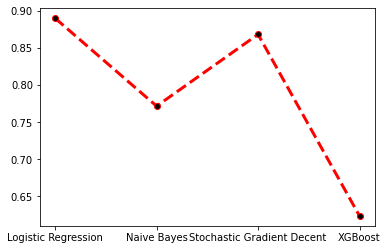

In [60]:
accuracy = models ['Test accuracy'].tolist()
model  = models ['Model'].tolist()

plt.plot( model,accuracy, label = 'Comparison between the classifier', 
      color='r', marker='o', markerfacecolor='k', 
      linestyle='--', linewidth=3)